In [1]:

import torch
import torch
from torch.utils.data import DataLoader
import pandas as pd
import glob

import segmentation_models_pytorch as smp

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import WandbLogger

from lightning_module import LitUNetPlusPlus
from config import Config
from dataset import *
from utils import plot_img_label_pred
from transforms import ImageVisualizer
import wandb
import seaborn as sns

import monai
from monai.transforms import *

from tabulate import tabulate
import matplotlib.pyplot as plt

seed_everything(99, workers=True)

from lightning.pytorch.plugins.environments import SLURMEnvironment
SLURMEnvironment.detect = lambda: False


Seed set to 99


In [ ]:
# globally set source domains for SVDNA and for dataset preppning
cfg = Config(source_domains = ["Cirrus"])
cfg.experiment_name = "Cirrus"
cfg.batch_size = 8
cfg.epochs = 150

In [3]:


train_data, val_data, test_data = OCTDatasetPrep(cfg.train_dir,
                                                 source_domains = cfg.source_domains
                                                ).get_datasets(dataset_split=[0.8, 0.2], use_official_testset=True)

train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
test_dataset = MakeDataset(test_data, cfg.test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=7, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)


In [ ]:

wandb_logger = WandbLogger(project="PracticalWorkinAI", name=cfg.experiment_name)

model = smp.UnetPlusPlus(**cfg.model_parameters_unetpp)
    
unetpp = LitUNetPlusPlus(cfg, model, experiment_name=cfg.experiment_name)


trainer = L.Trainer(max_epochs=cfg.epochs,
                    logger=wandb_logger,
                    default_root_dir=Path(cfg.default_root_dir),
                    log_every_n_steps=10,
                    callbacks=[cfg.checkpoint_callback, 
                               cfg.lr_monitor, 
                               cfg.aggregate_testing_results],
                    deterministic=True)

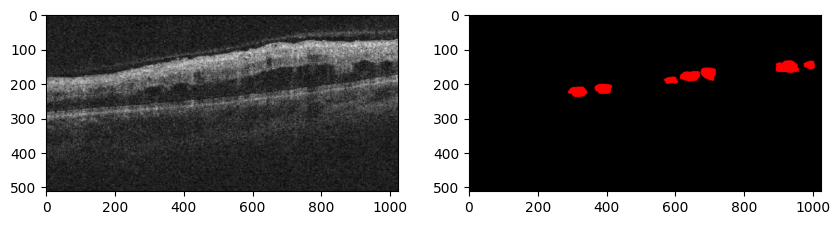

In [4]:
# randomly sample image
random_num = torch.randint(0, len(train_dataset), (1, ))
sample = train_dataset[random_num.item()]

img = sample['img']
mask = sample['masks']

#visualize images in subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0], cmap='gray')
ax[1].imshow(mask[1:].permute(1, 2, 0))
plt.show()

NameError: name 'cfg' is not defined

In [7]:
trainer.fit(unetpp, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(unetpp, dataloaders=test_loader)
wandb.finish

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

   | Name             | Type                | Params
----------------------------------------------------------
0  | model            | UnetPlusPlus        | 41.0 M
1  | loss_func1       | GeneralizedDiceLoss | 0     
2  | loss_func2       | BCEWithLogitsLoss   | 0     
3  | val_accuracy     | BinaryAccuracy      | 0     
4  | val_f1           | BinaryF1Score       | 0     
5  | val_precision    | BinaryPrecision     | 0     
6  | val_recall       | BinaryRecall        | 0     
7  | val_specificity  | BinarySpecificity   | 0     
8  | test_accuracy    | BinaryAccuracy      | 0     
9  | test_f1          | BinaryF1Score       | 0     
10 | test_precision   | BinaryPrecision     | 0     
11 | test_recall      | BinaryRecall        | 0     
12 | test_specificity | BinarySpecificity   | 0     
----------------------------------------------------------
41.0 M    Trainable params
0         Non-trainable params
41.0 M    Total params
163.976   Total 

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 4, global step 500: 'val_loss_total' reached 0.40406 (best 0.40406), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=04-val_loss_total=0.404-val_precision=0.740.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1000: 'val_loss_total' reached 0.39730 (best 0.39730), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=09-val_loss_total=0.397-val_precision=0.836.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 14, global step 1500: 'val_loss_total' reached 0.38952 (best 0.38952), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=14-val_loss_total=0.390-val_precision=0.777.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 19, global step 2000: 'val_loss_total' reached 0.35657 (best 0.35657), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=19-val_loss_total=0.357-val_precision=0.850.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 24, global step 2500: 'val_loss_total' reached 0.35370 (best 0.35370), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=24-val_loss_total=0.354-val_precision=0.813.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 29, global step 3000: 'val_loss_total' reached 0.37265 (best 0.35370), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=29-val_loss_total=0.373-val_precision=0.850.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 34, global step 3500: 'val_loss_total' reached 0.28436 (best 0.28436), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=34-val_loss_total=0.284-val_precision=0.802.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 39, global step 4000: 'val_loss_total' reached 0.27428 (best 0.27428), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=39-val_loss_total=0.274-val_precision=0.840.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 44, global step 4500: 'val_loss_total' reached 0.26078 (best 0.26078), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=44-val_loss_total=0.261-val_precision=0.814.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 49, global step 5000: 'val_loss_total' reached 0.26316 (best 0.26078), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=49-val_loss_total=0.263-val_precision=0.861.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 54, global step 5500: 'val_loss_total' reached 0.25395 (best 0.25395), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=54-val_loss_total=0.254-val_precision=0.832.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 59, global step 6000: 'val_loss_total' reached 0.24230 (best 0.24230), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=59-val_loss_total=0.242-val_precision=0.842.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 64, global step 6500: 'val_loss_total' reached 0.25712 (best 0.24230), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=64-val_loss_total=0.257-val_precision=0.842.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 69, global step 7000: 'val_loss_total' reached 0.23931 (best 0.23931), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=69-val_loss_total=0.239-val_precision=0.846.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 74, global step 7500: 'val_loss_total' reached 0.23869 (best 0.23869), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=74-val_loss_total=0.239-val_precision=0.833.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 79, global step 8000: 'val_loss_total' was not in top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 84, global step 8500: 'val_loss_total' reached 0.24167 (best 0.23869), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=84-val_loss_total=0.242-val_precision=0.851.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 89, global step 9000: 'val_loss_total' reached 0.23756 (best 0.23756), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=89-val_loss_total=0.238-val_precision=0.849.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 94, global step 9500: 'val_loss_total' was not in top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 99, global step 10000: 'val_loss_total' reached 0.23687 (best 0.23687), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=99-val_loss_total=0.237-val_precision=0.840.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 104, global step 10500: 'val_loss_total' reached 0.23634 (best 0.23634), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_only_histmatching/experiment_name=0-epoch=104-val_loss_total=0.236-val_precision=0.849.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 109, global step 11000: 'val_loss_total' was not in top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 114, global step 11500: 'val_loss_total' was not in top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 119, global step 12000: 'val_loss_total' was not in top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 124, global step 12500: 'val_loss_total' was not in top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 129, global step 13000: 'val_loss_total' was not in top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 134, global step 13500: 'val_loss_total' was not in top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 139, global step 14000: 'val_loss_total' was not in top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 144, global step 14500: 'val_loss_total' was not in top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 149, global step 15000: 'val_loss_total' was not in top 3
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: |                                              | 0/? [00:00<?, ?it/s]

+------------+--------------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
|    Task    |          Model           |      Accuracy      |         F1          |      Precision      |       Recall        |     Specificity     |
+------------+--------------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
| Background | cirrus_only_histmatching | 0.9897687284464247 | 0.9946821285097787  | 0.9924993384420202  | 0.9970888975407747  | 0.28666369716685014 |
|    IRF     | cirrus_only_histmatching | 0.9983253523651581 | 0.2318220295706129  | 0.2901790495264285  | 0.21944236181578722 | 0.9994977761743667  |
|    PED     | cirrus_only_histmatching | 0.994844824187318  | 0.0947076874496921  | 0.19945372585276985 | 0.0771705176713327  | 0.9997769402207507  |
|    SRD     | cirrus_only_histmatching | 0.9986283163006386 | 0.15838782756313793 | 0.2143488

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_loss_ce        │   0.028577543795108795    │
│      test_loss_dice       │    0.24983040988445282    │
│      test_loss_total      │    0.2641191780567169     │
└───────────────────────────┴───────────────────────────┘

<function wandb.sdk.wandb_run.finish(exit_code: Optional[int] = None, quiet: Optional[bool] = None) -> None>

In [4]:
experiments = os.listdir(cfg.model_path)[1:]
experiments

['supervised-epoch=134-val_loss_total=0.26-val_precision=0.85.ckpt',
 'initial_model.ckpt',
 'spectr-epoch=139-val_loss_total=0.29-val_precision=0.84.ckpt']

In [9]:
test_all_models = True

if test_all_models:
    
    experiments = os.listdir(cfg.model_path)[1:]
    for exp in experiments:
        model = list(Path(cfg.model_path / exp).glob("*.ckpt"))[0]
        wandb_logger = WandbLogger(project="PracticalWorkinAI", name=exp)
        
        model_eval = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = model, experiment_name=exp)
    
        trainer = L.Trainer(max_epochs=cfg.epochs, 
                            logger=wandb_logger,
                            default_root_dir=Path(cfg.default_root_dir),
                            log_every_n_steps=10,
                            callbacks=[checkpoint_callback, 
                                       lr_monitor, 
                                       #early_stopping,
                                       aggregate_testing_results],
                            deterministic=True)
        
        trainer.test(model_eval, dataloaders=test_loader)
        wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: |                                              | 0/? [00:00<?, ?it/s]

+------------+-------------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
|    Task    |          Model          |      Accuracy      |         F1          |      Precision      |       Recall        |     Specificity     |
+------------+-------------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
| Background | supervised_full_dataset | 0.9928210338626462 | 0.9962601989842532  | 0.9951943073156622  | 0.9974217935001359  | 0.39478171787011934 |
|    IRF     | supervised_full_dataset | 0.9982007277592291 | 0.26403494434207087 | 0.28141957367820514 | 0.2707501713898075  | 0.9990064771880818  |
|    PED     | supervised_full_dataset | 0.9964291001303812 | 0.16852780994749889 | 0.2256945663607899  | 0.15156478915461216 | 0.9994758973630626  |
|    SRD     | supervised_full_dataset | 0.9990743889790795 | 0.19112983674913198 | 0.22592731314093

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_loss_ce        │    0.01776251569390297    │
│      test_loss_dice       │    0.18734173476696014    │
│      test_loss_total      │    0.1962229609489441     │
└───────────────────────────┴───────────────────────────┘

epoch,▁
test_loss_ce,▁
test_loss_dice,▁
test_loss_total,▁
trainer/global_step,▁
epoch,0
test_loss_ce,0.01776
test_loss_dice,0.18734
test_loss_total,0.19622
trainer/global_step,0


/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: |                                              | 0/? [00:00<?, ?it/s]

+------------+--------------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
|    Task    |          Model           |      Accuracy      |         F1          |      Precision      |       Recall        |     Specificity     |
+------------+--------------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
| Background | source_spectralis_topcon | 0.9926940505201004 | 0.9961940658449681  | 0.9952339928471641  | 0.9972539643446604  | 0.39320684712701076 |
|    IRF     | source_spectralis_topcon | 0.9982408976063746 | 0.24957244018483418 | 0.24689449816645725 | 0.2806637090969175  | 0.9989262607213709  |
|    PED     | source_spectralis_topcon | 0.9962544234727653 |  0.154806804285151  | 0.22491632573906514 | 0.13541273991769173 | 0.9994806918535339  |
|    SRD     | source_spectralis_topcon | 0.9989334319191479 | 0.1905083198253805  | 0.2162004

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_loss_ce        │   0.017871657386422157    │
│      test_loss_dice       │    0.20160217583179474    │
│      test_loss_total      │    0.21053797006607056    │
└───────────────────────────┴───────────────────────────┘

epoch,▁
test_loss_ce,▁
test_loss_dice,▁
test_loss_total,▁
trainer/global_step,▁
epoch,0
test_loss_ce,0.01787
test_loss_dice,0.2016
test_loss_total,0.21054
trainer/global_step,0


/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: |                                              | 0/? [00:00<?, ?it/s]

+------------+-------------------+--------------------+---------------------+---------------------+---------------------+--------------------+
|    Task    |       Model       |      Accuracy      |         F1          |      Precision      |       Recall        |    Specificity     |
+------------+-------------------+--------------------+---------------------+---------------------+---------------------+--------------------+
| Background | source_spectralis | 0.9909034030937524 | 0.9952714448787746  | 0.9934548282444701  | 0.9972314708465048  | 0.3767042465548097 |
|    IRF     | source_spectralis | 0.9979265659266197 | 0.22714991351129132 | 0.22639807613133994 | 0.2708456686415364  | 0.9988142274292221 |
|    PED     | source_spectralis | 0.9952671089199152 | 0.13420935402330436 | 0.20155946743039743 | 0.12127795443887132 | 0.9993551568815324 |
|    SRD     | source_spectralis | 0.9975538987122224 |  0.13127819207333   | 0.21176241887628697 | 0.11688508601224377 | 0.9996526453378942 |

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_loss_ce        │    0.0250503271818161     │
│      test_loss_dice       │    0.25820451974868774    │
│      test_loss_total      │    0.27072951197624207    │
└───────────────────────────┴───────────────────────────┘

epoch,▁
test_loss_ce,▁
test_loss_dice,▁
test_loss_total,▁
trainer/global_step,▁
epoch,0
test_loss_ce,0.02505
test_loss_dice,0.2582
test_loss_total,0.27073
trainer/global_step,0


/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: |                                              | 0/? [00:00<?, ?it/s]

+------------+---------------+--------------------+---------------------+---------------------+---------------------+---------------------+
|    Task    |     Model     |      Accuracy      |         F1          |      Precision      |       Recall        |     Specificity     |
+------------+---------------+--------------------+---------------------+---------------------+---------------------+---------------------+
| Background | source_topcon | 0.9703264170594876 | 0.9843039968040552  | 0.9928672612829601  | 0.9767727351813728  | 0.31510163235307187 |
|    IRF     | source_topcon | 0.9978111620699421 | 0.21733371048733202 | 0.23675027853383748 | 0.22788253462479244 | 0.9989370749461071  |
|    PED     | source_topcon | 0.9948717334520504 | 0.11384179459634927 | 0.20218471223921192 | 0.09260177220852718 | 0.9993620322884692  |
|    SRD     | source_topcon | 0.9981981578391143 | 0.14604990976105692 | 0.19655696498727154 | 0.12858918524601878 | 0.9997693687565764  |
+------------+------

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_loss_ce        │    0.04876565560698509    │
│      test_loss_dice       │    0.2575976848602295     │
│      test_loss_total      │    0.28198057413101196    │
└───────────────────────────┴───────────────────────────┘

epoch,▁
test_loss_ce,▁
test_loss_dice,▁
test_loss_total,▁
trainer/global_step,▁
epoch,0
test_loss_ce,0.04877
test_loss_dice,0.2576
test_loss_total,0.28198
trainer/global_step,0


/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: |                                              | 0/? [00:00<?, ?it/s]

+------------+---------------+--------------------+---------------------+---------------------+---------------------+---------------------+
|    Task    |     Model     |      Accuracy      |         F1          |      Precision      |       Recall        |     Specificity     |
+------------+---------------+--------------------+---------------------+---------------------+---------------------+---------------------+
| Background | source_cirrus | 0.9870639726910252 | 0.9932884789361489  | 0.9913765083761251  | 0.9955005194810446  | 0.22935151198213094 |
|    IRF     | source_cirrus | 0.9984204237827201 | 0.23823416229225836 | 0.2980513923874732  | 0.2203799153430464  |  0.999581015511845  |
|    PED     | source_cirrus | 0.9938989684599616 |         0.0         |         0.0         |         0.0         |         1.0         |
|    SRD     | source_cirrus | 0.9989268555400077 | 0.1694410305397414  | 0.22900447122794523 | 0.14798454372303854 | 0.9998575893234224  |
+------------+------

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_loss_ce        │    0.03381016105413437    │
│      test_loss_dice       │    0.2846337854862213     │
│      test_loss_total      │    0.3015389144420624     │
└───────────────────────────┴───────────────────────────┘

epoch,▁
test_loss_ce,▁
test_loss_dice,▁
test_loss_total,▁
trainer/global_step,▁
epoch,0
test_loss_ce,0.03381
test_loss_dice,0.28463
test_loss_total,0.30154
trainer/global_step,0


/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: |                                              | 0/? [00:00<?, ?it/s]

+------------+----------------------------+--------------------+---------------------+---------------------+---------------------+--------------------+
|    Task    |           Model            |      Accuracy      |         F1          |      Precision      |       Recall        |    Specificity     |
+------------+----------------------------+--------------------+---------------------+---------------------+---------------------+--------------------+
| Background | spectralis_topcon_no-svdna | 0.9921623045362337 |  0.995918612243531  | 0.9940654155466887  | 0.9978908308213124  | 0.350313335386356  |
|    IRF     | spectralis_topcon_no-svdna | 0.9981544852703251 | 0.23395560604035295 | 0.24437278799698706 | 0.25207829082991634 | 0.9989698995811662 |
|    PED     | spectralis_topcon_no-svdna | 0.9955094176508514 | 0.11351792712655348 | 0.21851903618111063 | 0.09769886307943088 | 0.9995884068226546 |
|    SRD     | spectralis_topcon_no-svdna | 0.9986815546335799 | 0.1755400218264887  | 0

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_loss_ce        │    0.02285889722406864    │
│      test_loss_dice       │     0.240585058927536     │
│      test_loss_total      │    0.25201448798179626    │
└───────────────────────────┴───────────────────────────┘

epoch,▁
test_loss_ce,▁
test_loss_dice,▁
test_loss_total,▁
trainer/global_step,▁
epoch,0
test_loss_ce,0.02286
test_loss_dice,0.24059
test_loss_total,0.25201
trainer/global_step,0


/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: |                                              | 0/? [00:00<?, ?it/s]

+------------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
|    Task    |        Model        |      Accuracy      |         F1          |      Precision      |       Recall        |     Specificity     |
+------------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
| Background | spectralis_no-svdna | 0.9887858995337612 | 0.9942144485895107  | 0.9894433684563368  | 0.9992483311824585  | 0.13898720192096317 |
|    IRF     | spectralis_no-svdna | 0.9970452187213112 | 0.11684656197161367 | 0.2165574205111475  | 0.10769149455688663 | 0.9996972482525901  |
|    PED     | spectralis_no-svdna | 0.9948050874226102 | 0.05691180291919937 | 0.13374988687480188 | 0.0506397646503491  | 0.9998421214716264  |
|    SRD     | spectralis_no-svdna | 0.9968712834383218 | 0.04116727751095462 | 0.14676960097270064 | 0.03862363016479195 | 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_loss_ce        │    0.04053100198507309    │
│      test_loss_dice       │    0.41538143157958984    │
│      test_loss_total      │    0.43564677238464355    │
└───────────────────────────┴───────────────────────────┘

epoch,▁
test_loss_ce,▁
test_loss_dice,▁
test_loss_total,▁
trainer/global_step,▁
epoch,0
test_loss_ce,0.04053
test_loss_dice,0.41538
test_loss_total,0.43565
trainer/global_step,0


In [11]:
checkpoint = path / model_checkpoints[0]

model_eval = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = checkpoint, experiment_name=experiment_name)

trainer = L.Trainer(max_epochs=cfg.epochs, 
                    logger=wandb_logger,
                    default_root_dir=Path(cfg.default_root_dir),
                    log_every_n_steps=10,
                    callbacks=[checkpoint_callback, 
                               lr_monitor, 
                               #early_stopping,
                               aggregate_testing_results],
                    deterministic=True)

#trainer.test(model_eval, dataloaders=test_loader)
#wandb.finish()

/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Visualization and results

### Visualize some images and masks

In [12]:
print_some_imgs = False

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)


    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape,
              "\nMasks: ", sample['masks'].shape)




### Load model and make predictions on random images from validation set

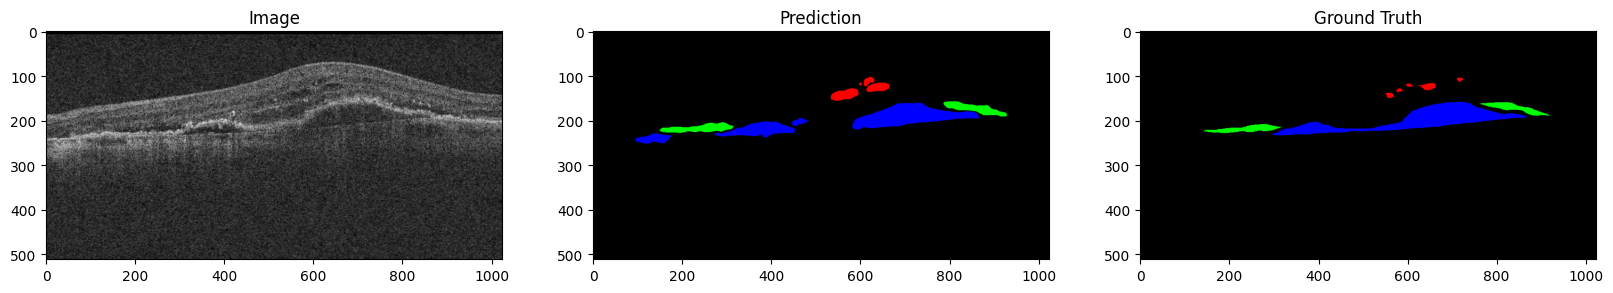

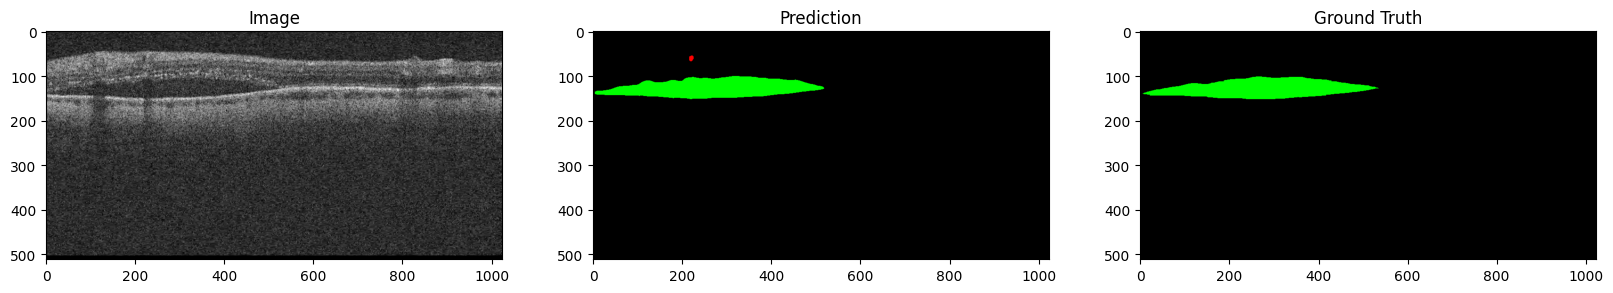

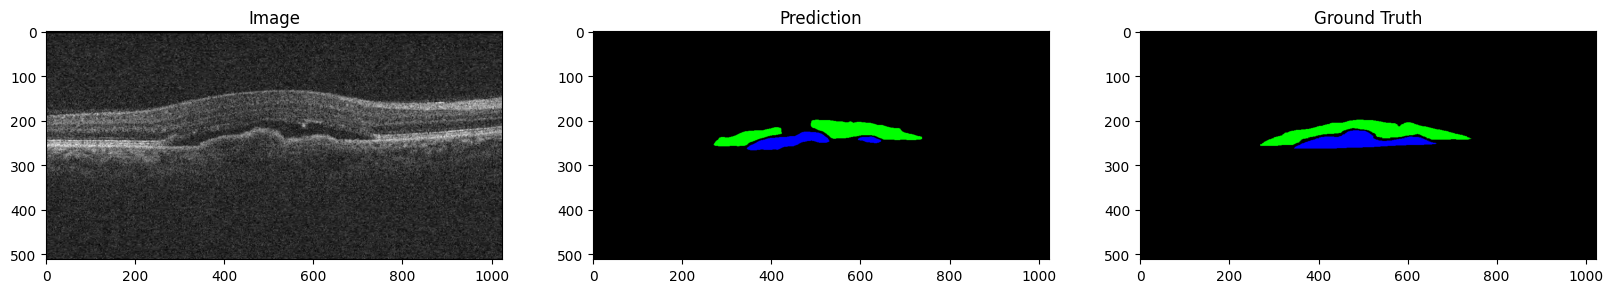

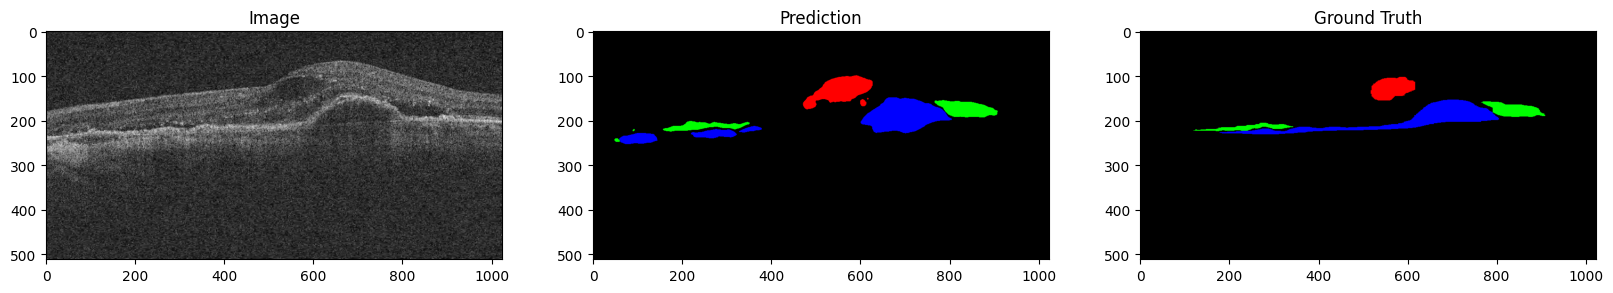

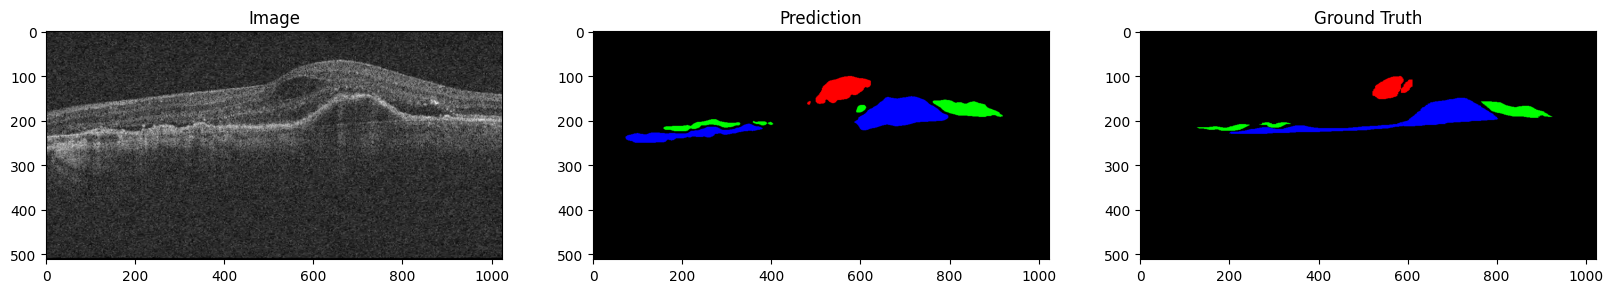

In [15]:
get_predictions = True

if get_predictions:
    model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = checkpoint, experiment_name=experiment_name)
    model.eval()

    for i in range(np.min([5, len(val_dataset)])):
        rand_num = np.random.randint(0, len(val_dataset))
        sample = val_dataset[rand_num]

        img = sample['img'].unsqueeze(0).to(cfg.device)
        mask = sample['masks'].unsqueeze(0).to(cfg.device)

        pred = model(img)
        pred = torch.sigmoid(pred)
        
        # thresholding
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0

        plot_img_label_pred(img, pred, mask)

## Create results tables from saved csv

In [2]:

# Get the path to the "results" folder
results_folder = os.path.join(os.getcwd(), "results")

# Get all files in the "results" folder that match the pattern "results_mean_*.csv"
file_list = glob.glob(os.path.join(results_folder, "*/results_raw_*.csv"), recursive=True)

# Load each file into a pandas DataFrame and concatenate them
dfs = []
for file in file_list:
    file_path = os.path.join(results_folder, file)
    df = pd.read_csv(file_path, index_col=0)
    dfs.append(df)

result = pd.concat(dfs)

means = result.groupby(["Task", "Model"]).mean().round(3)
stds = result.groupby(["Task", "Model"]).std().round(3)

# combine the two dataframes such that the result has "mean (std)" format
result = means.astype(str) + " (" + stds.astype(str) + ")" 

# tabulate
print(tabulate(result, headers='keys', tablefmt='fancy_grid'))
result.to_latex("results.tex")


╒════════════════════════════════════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│                                                    │ Accuracy      │ F1            │ Precision     │ Recall        │ Specificity   │
╞════════════════════════════════════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ ('Background', 'cirrus_no_svdna')                  │ 0.982 (0.035) │ 0.991 (0.019) │ 0.99 (0.021)  │ 0.992 (0.027) │ 0.17 (0.282)  │
├────────────────────────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ ('Background', 'cirrus_only_histmatching')         │ 0.99 (0.02)   │ 0.995 (0.011) │ 0.992 (0.018) │ 0.997 (0.011) │ 0.287 (0.308) │
├────────────────────────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ ('Background', 'cirrus_svdna_no_Histmatching')     │ 

['trial', 'spectralis_tinytest', 'supervised_tinytest']


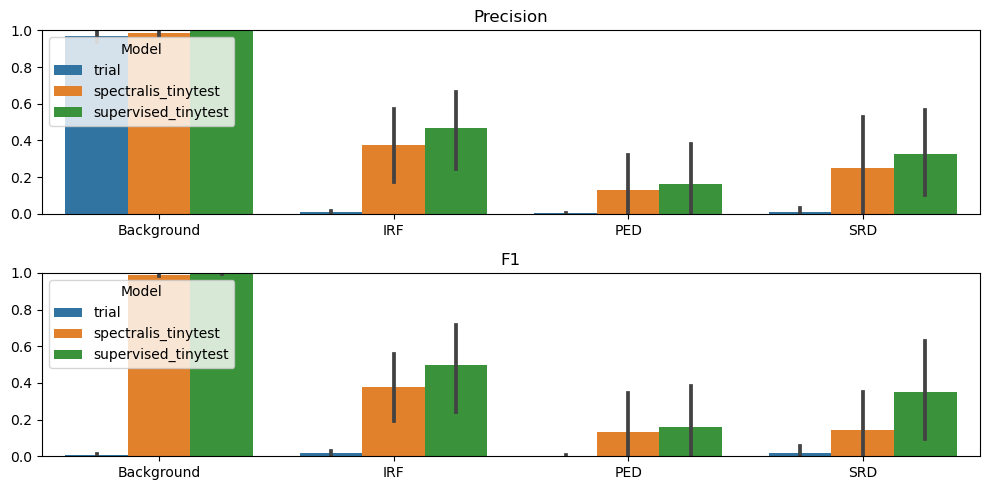

In [45]:

# Get the path to the "results" folder
results_folder = os.path.join(os.getcwd(), "results")

# Get all files in the "results" folder that match the pattern "results_mean_*.csv"
file_list = [file for file in os.listdir(results_folder) if file.startswith("results_raw_") and file.endswith(".csv")]

# Load each file into a pandas DataFrame and concatenate them
dfs = []
for file in file_list:
    file_path = os.path.join(results_folder, file)
    df = pd.read_csv(file_path, index_col=0)
    dfs.append(df)

result = pd.concat(dfs)


# melt the dataframe
result_melted = pd.melt(result, id_vars=["Model", "Task"], value_vars=["Accuracy", "F1", "Precision", "Recall", "Specificity"], var_name="Metric")

# create 2 subplots, one for each metric
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

# Get a sorted list of unique model names, with "trials" first
task_order = sorted(result_melted["Task"].unique())
model_order = sorted(result_melted["Model"].unique())
model_order.insert(0, model_order.pop(model_order.index('trial')))
print(model_order)

# Only plot Precision and F1
for i, metric in enumerate(["Precision", "F1"]):
    data = result_melted[result_melted["Metric"] == metric]
    data = data.sort_values('value', ascending=True)  # sort the data by value

    # Pass the model_order list to the order parameter
    sns.barplot(data=data, x="Task", y="value", hue="Model", ax=axes[i], order=task_order, hue_order=model_order)

    axes[i].set_title(metric)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].legend(loc='upper left', title="Model")

plt.tight_layout()
plt.show()